## Understanding Random Forests

In this notebook, I am going to be implementing a Random Forests Model from "scratch" on the Titanic Classifcation problem in order to dive deep in understanding how Random Forests really work under the hood.

## Data Processing

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read data and show the most common values in each feature
data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
modes = data.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

The difference with Random Forests and Linear Models or Neural Networks is that we don't have to create dummy variables for non-numerical columns. Instead we convert those fields into categorical variables.

In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0) # Fills empty values with 0
    df.fillna(modes, inplace=True) # Fills the empty values with the most common value
    df['LogFare'] = np.log1p(df['Fare']) # Replaces the fare with the log(1 + x)
    df['Embarked'] = pd.Categorical(df.Embarked) # Converts feature into a Categorical Variable
    df['Sex'] = pd.Categorical(df.Sex) # Converts feature into a Categorical Variable

proc_data(data)
proc_data(test_data)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765


Under the hood, a Categorical Variable makes a list of all the unique values in a column and replaces each value with a number. This way the number is an index for looking up the value in the list of unique values similar to a dictionary.

In [5]:
data.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

Notice that for this categorical variable, it still shows the original value (Male, Female), but behind the scene it has `Categories (2, object): ['female', 'male']` which means they are stored as integers with indicies that are looked up in the `Categories` list. We can view the stored values with the `cat.codes` attribute.

In [6]:
data.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

Now we'll make a list of continuous, categorical, and dependent values. Notice `Pclass` is no longer considered a categorical value because it has an order "1,2, or 3."

In [7]:
categorical=['Sex', 'Embarked']
continuous=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dependent='Survived'

## Binary Splits

In order to create Random Forests, we need to create decision trees, which are what Random Forests are made out of.

Decision trees are made of binary splits on the data. A binary split is where all rows of data are split between one or two groups, whether they are above or below some threshold. 

For example: we can split the Sex Feature with a threshold of `0.5` because the categorical values for sex are `0` or `1`.

C:\Users\tuvshno\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\tuvshno\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


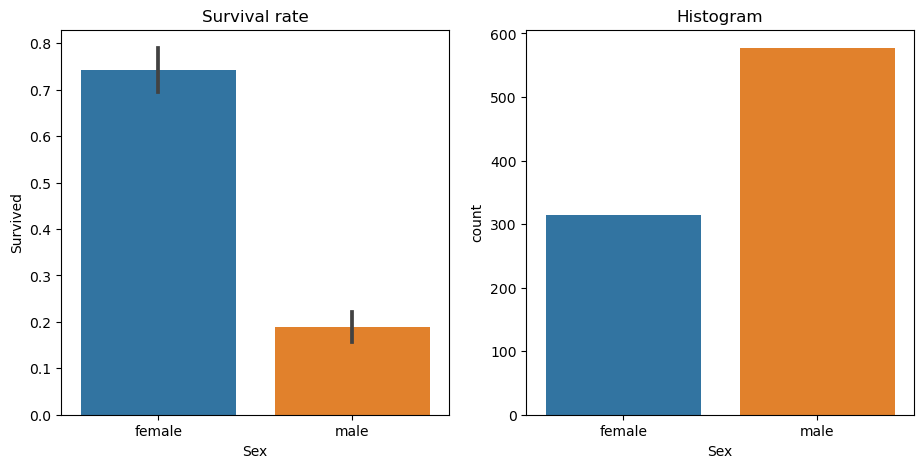

In [8]:
import seaborn as sns

fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=data, y=dependent, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=data, x="Sex", ax=axs[1]).set(title="Histogram");                                                     

Here we can see that if we split the data into two groups for sex, there is a survival rate of around >70% for females and <20% for males.

We could create a "model" which says that if the passenger is female, she survives.

In [9]:
from numpy import random
from sklearn.model_selection import train_test_split

trn_df, val_df = train_test_split(data, test_size=0.25) # Split the train and validation sets
trn_df[categorical] = trn_df[categorical].apply(lambda x: x.cat.codes) # Convert the categorical variables to their number
val_df[categorical] = val_df[categorical].apply(lambda x: x.cat.codes)  # Convert the categorical variables to their number

In the above step, we split the training and validation data and transformed our categorical variables to their numerical counterpart.

Now we can create our independent and dependent variables.

In [10]:
def xs_y(df):
    xs = df[categorical+continuous].copy()
    return xs, df[dependent] if dependent in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

These are our predictions for the model where females survive.

In [11]:
preds = val_xs.Sex==0
preds

819    False
107    False
744    False
323     True
340    False
       ...  
563    False
570    False
322     True
137    False
302    False
Name: Sex, Length: 223, dtype: bool

In [12]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.18385650224215247

Instead of splitting on a categorical variable, we can split on a continuous variable such as `logFare`. 

C:\Users\tuvshno\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tuvshno\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tuvshno\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='LogFare', ylabel='Density'>

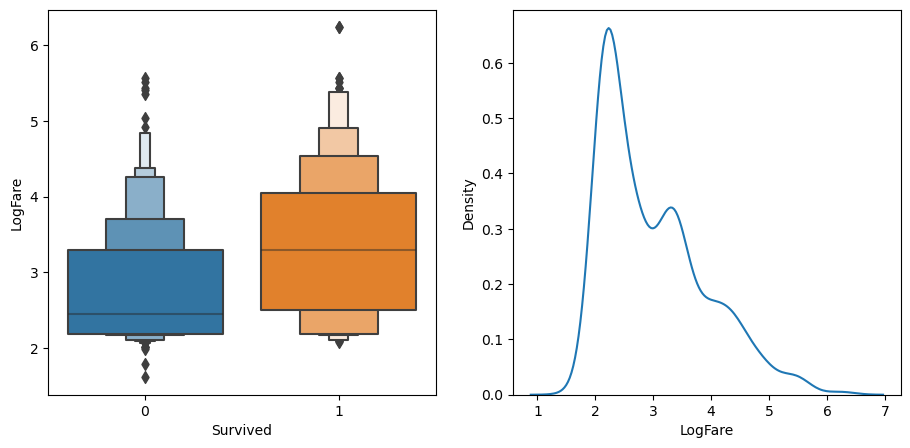

In [13]:
df_fare = trn_df[trn_df.LogFare > 0]
fig, axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dependent, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1])

The boxenplot above shows the quantiles of LogFare for each group `Survived == 0` and `Survived == 1`. It shows that the average logfare for passengers that didn't survive waqs around `2.5` and survived passengers was around `3.2`. So if you paid more for your ticket the more likely you could have survived.

In [14]:
preds = val_xs.LogFare>2.7
mean_absolute_error(val_y, preds)

0.3542600896860987

We've tried two split points for `Sex` and `LogFare`. Now we'd like to try out more split points for each column to find the best possible split points.

Here's how we could do that for `Age`

In [15]:
nm = 'Age' # Feature name
col = trn_xs[nm] # Get all the rows from the feature
unq = col.unique() # Get all the unique values 
unq.sort() # Sort for better visualization
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 11.  , 12.  , 13.  , 14.  ,
       14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 , 21.  ,
       22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  , 28.  ,
       28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  , 34.  ,
       34.5 , 35.  , 36.  , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  ,
       42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  ,
       50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 56.  , 57.  , 58.  ,
       59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 70.  ,
       70.5 , 71.  , 74.  ])

In order to find the best score for them, we could use the measure of `impurity` which is a measure of the likelihood of an incorrect classification of a randomly selected data point. We could measure the similarity of the rows by taking the standard deviation of the dependent variable. 

If it is higher then that means the rows are more different to each other, meaning they answered differently from each other more often. We'll then multiply this by the number of rows since a bigger group has more impact than a smaller group.

In [16]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot
        
def score(col, y, split):
    lhs = col<=split # Getting the left and side of the "split" of the specied "col"
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y) # Returning the scores of the left and right hand side

Now we can find which split scored the lowest for Age.

In [17]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

0.92

This means that the most optimal split is 6.

Now we can write a function that implements this idea:

In [18]:
def min_col(df, nm):
    col, y = df[nm], df[dependent] # Get the Rows for that feature and the dependent variable
    unq = col.dropna().unique() # Collect all the unique values for that feature
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)]) # Calculate the scores for each unique value
    idx = scores.argmin() # Find the value of the lowest score
    return unq[idx], scores[idx] # Return the value and its score

In [19]:
min_col(trn_df, "Age")

(0.92, 0.4753472236859963)

Now we can do all the features:

In [20]:
cols = categorical+continuous
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4128496335545108),
 'Embarked': (0, 0.47211011124864427),
 'Age': (0.92, 0.4753472236859963),
 'SibSp': (4, 0.47539954347088925),
 'Parch': (0, 0.4783782811394168),
 'LogFare': (3.8732821771117156, 0.4611329759446849),
 'Pclass': (2, 0.45680605969958216)}

According to the data, `Sex<=0` is the best split.

This is called the OneR classifier, which is suprisingly one of the most effect classifiers. Since its so simple, it makes for a great baseline.

## Creating a Decision Tree

Now we want to improve the OneR classifier that only split based on `Sex`.

In order to do this, we could keep splitting based off the best split in the original split.

Meaning that after we split on `Sex` between `Female` and `Male`, we could continue splitting for both `Female` and `Male`.

In order to do that, we need to remove `Sex` from the cols and split our data into two groups

In [21]:
cols

['Sex', 'Embarked', 'Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']

In [22]:
cols.remove("Sex")
isMale = trn_df.Sex==1
males, females = trn_df[isMale], trn_df[~isMale]

Now we want to find the best split for males:

In [23]:
{o: min_col(males, o) for o in cols}

{'Embarked': (0, 0.3836040020185199),
 'Age': (12.0, 0.37500322863869534),
 'SibSp': (4, 0.3861250871739465),
 'Parch': (0, 0.3862814273244743),
 'LogFare': (3.305053521109253, 0.3690595819081184),
 'Pclass': (1, 0.370627280132763)}

And the best split for females:

In [24]:
{o: min_col(females, o) for o in cols}

{'Embarked': (0, 0.4437598901898941),
 'Age': (57.0, 0.44692121336571633),
 'SibSp': (2, 0.4263298533279017),
 'Parch': (3, 0.447363934352049),
 'LogFare': (4.256321678298823, 0.39413178309571123),
 'Pclass': (2, 0.358649380592919)}

We can see that the best split for `Male` is  `LogFare` and for `Female` is `Pclass`

By adding these rules, we've created a Deicison Tree, where the model will first check if whether Sex is male or female and then check LogFare or Pclass. We could then repeat the process for more splits.

We can utilize the DecisionTreeClassifier from sklearn to do this for us.

In [25]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [26]:
import graphviz
import re 

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

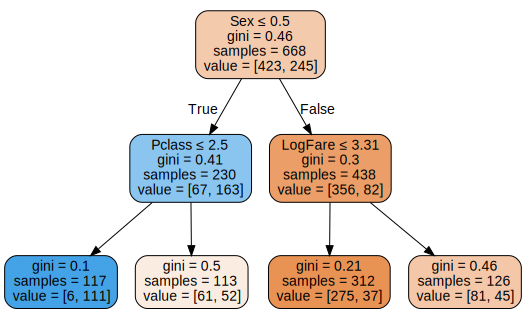

In [27]:
draw_tree(m, trn_xs, size=10)

The graph shows a decision tree and where it splits. The blue nodes show higher chance of survival where the organe nodes show lower chance of survival.

Each node has a "sample" which indicate how many rows match that node. "Gini" is another measure of impurity. Value shows how many values were either not survived or survived.

We could also make a bigger tree.

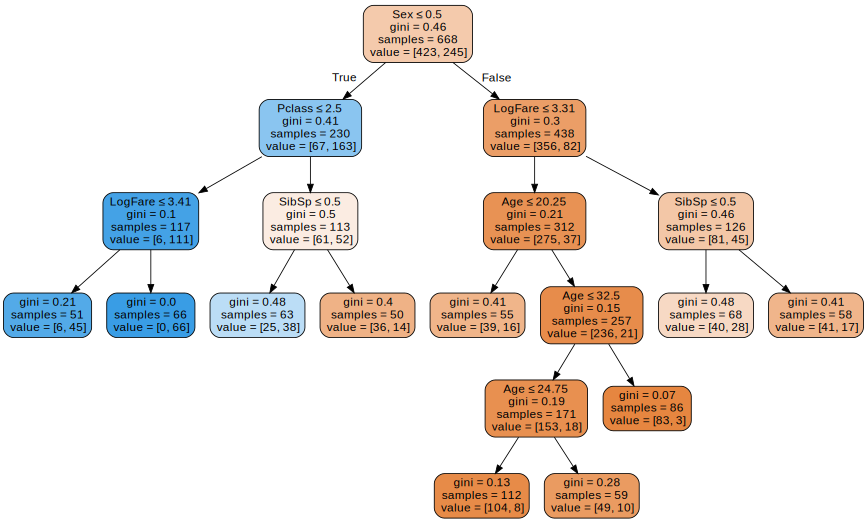

In [28]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [29]:
mean_absolute_error(val_y, m.predict(val_xs))

0.21524663677130046

## Random Forests

The ideology of Random Forests is based on the idea of bagging. Due to the fact that we can't make bigger trees than the one above, as they have already reached samples of 50, we could instead make lots of trees and take the average of their predictions. This is called bagging. The reason why this works is because the average of lots of uncorrelated random errors in zero! But this adds an additional caveat to making the decison trees, they must be from random subsets of data so we can make a bunch of uncorrelated models.

In [44]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop)) # Get random indexes 
    # Returning a fitted decision tree based on those random indexes 
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [45]:
trees = [get_tree() for t in range(100)]
trees[:5]

[DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5),
 DecisionTreeClassifier(min_samples_leaf=5)]

Our prediction will be the average of all the trees.

In [47]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.226457399103139

This is similar to what `sklearn`'s `RandomForestClassifier` does. The only addition is that it also takes a random subset of features along with the random subset of data.

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

Notice we our implementation of Random Forest's were had a little bit more error than the `sklearn` Random Forest Model

Another great thing about Random Forests is that it has great diagnostic tools to help us understand how our data is affecting the predictions.

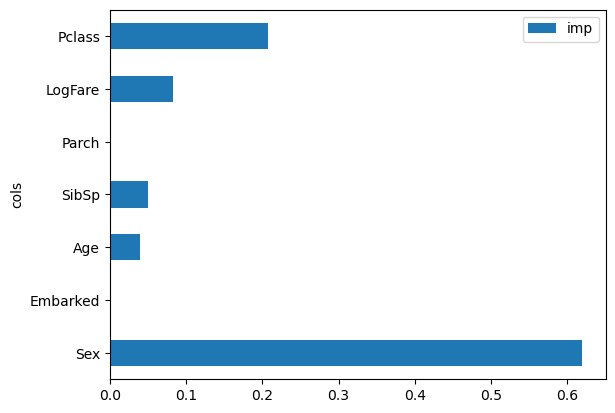

In [51]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

This data shows which feature is the most important predictor. 

## Conclusion

This notebook has shown how to build Random Forests from a simple OneR Model. This notebook really showed how "simple" models can be performant on tabular data. They are more straightfoward to utilize and can provide detailed insights on the data faster than other models.

Another great thing about Random Forests is that they are not very complicated. We were able to implement the important factors of a Random Forest Model inside of this notebook fairly quickly. They are also not sensitive to issues such as normalization, interaction, or non-linear transoformations unlike other models, which make them easier to work with and harder to mess up!
